# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import re
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
!pip install matplotlib

In [3]:
# Define Plot Color
blue = sns.color_palette()[0]
# Plot Style
plt.style.use('seaborn')
# Define Matplotlib Params
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.figsize'] = (12, 9)
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['figure.titlesize'] = 'xx-large' 
mpl.rcParams['axes.titlesize'] = 'large' 

#mpl.rcParams['axes.titley'] = 1.03 

In [4]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [5]:
# load data from database
engine = create_engine('sqlite:///DisasterResponse.db')
df = pd.read_sql_table('labeled_messages', engine)
X = df.iloc[:,1]
y = df.iloc[:,4:]

In [6]:
## Extract the disaster labels
labels = list(y.columns)

In [7]:
## Check which text messages have assigned labels
disasters_assigned = pd.DataFrame(y.sum(axis=1), columns=['Sum']).sort_values(by='Sum', ascending=False)

In [8]:
## Disasters with the count of assigned labels
disasters_assigned.head(5)

,Sum
20844,27
13671,27
24930,24
14719,22
10171,22


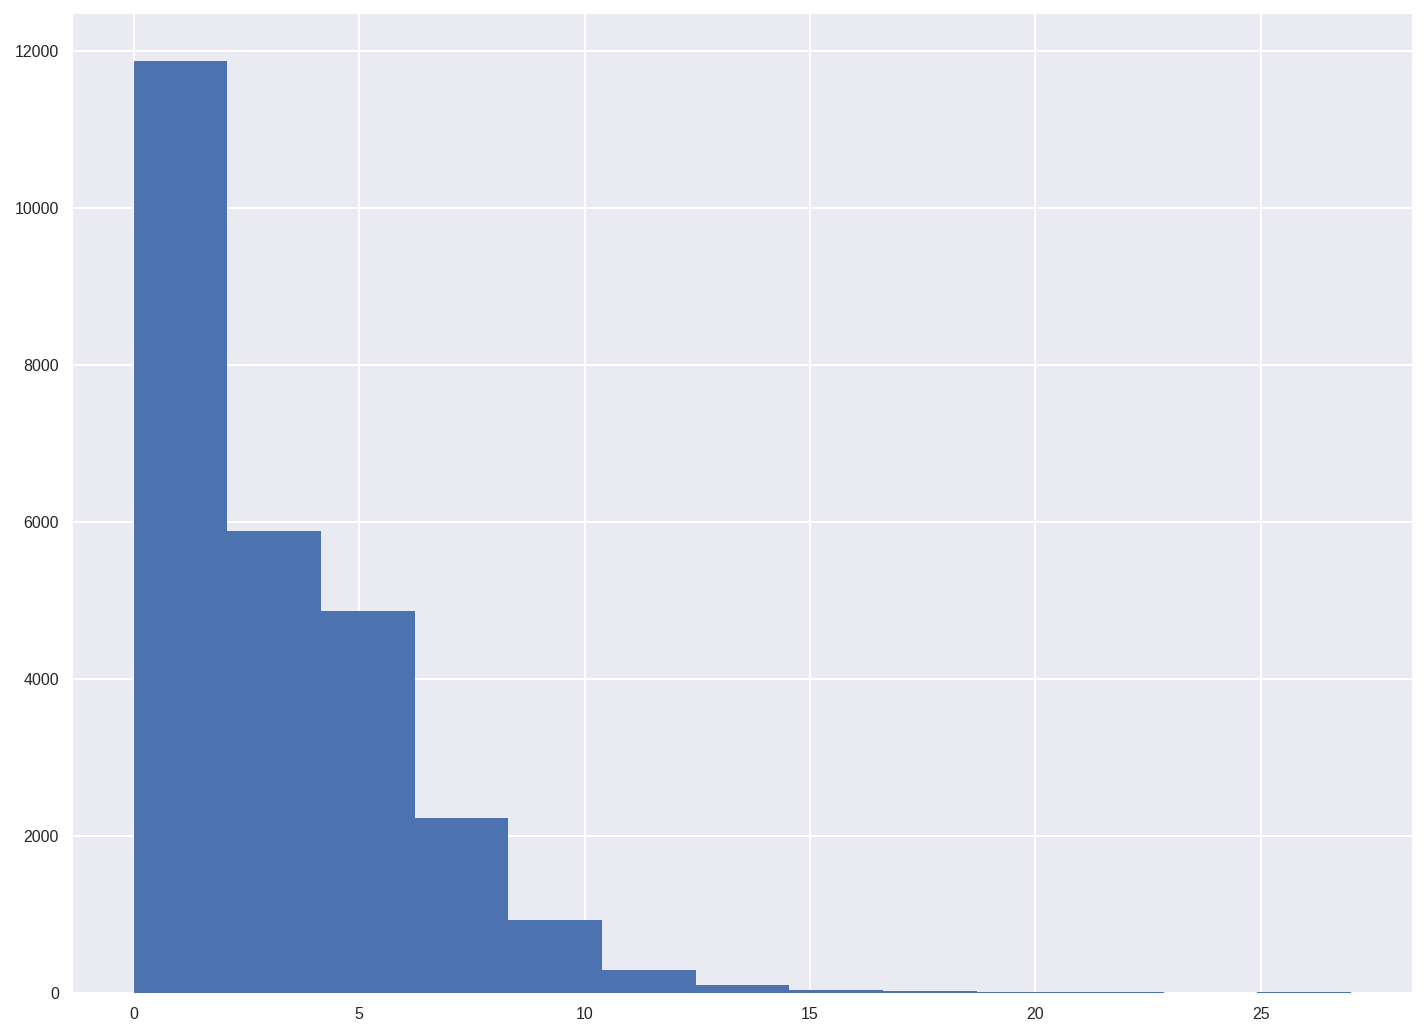

In [9]:
## Histogram of assigned labels 
plt.hist(x=disasters_assigned.Sum, bins=13);

Most disaster messages are labeled with one label. Additional there are many disasters that are labeled with wore than one label:

### 2. Write a tokenization function to process your text data

In [10]:
def tokenize(text):
    # Step 1 Normalisation
    text = re.sub(r'[^A-Za-z0-9]', ' ', text.lower())
    
    # Step 2 Tokenzation
    words = word_tokenize(text)
    
    #Step 3 Lemmatization
    tokens = [WordNetLemmatizer().lemmatize(word=w) for w in words]
    
    return tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [11]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier()))
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [131]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...oob_score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=1))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [132]:
y_pred = pipeline.predict(X_test)


In [133]:
y_pred = pd.DataFrame((y_pred), columns=y_test.columns)

In [134]:
metric_complete = pd.DataFrame(columns=['index', 'metric', 'metric_value', 'label'])

In [136]:
metric_complete.head()

,index,metric,metric_value,label


In [137]:

for label in labels:
    metric = precision_recall_fscore_support(y_test.loc[:,label], y_pred.loc[:,label])
    metric_df = pd.DataFrame({'precision': metric[0], 'recall': metric[1], 'fscore': metric[2]})
    metric_df = metric_df.reset_index().melt(id_vars='index', var_name='metric', value_name='metric_value')
    metric_df['label'] = label

    metric_complete = pd.concat([metric_complete, metric_df])
    

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [138]:


metric_true = metric_complete.query('index == 1').pivot(index='label', columns='metric', values='metric_value').sort_values(by=['recall', 'fscore'], ascending=False).reset_index()
metric_true.columns.name = None
metric_true.head(3)


,label,fscore,precision,recall
0,related,0.875283,0.825662,0.931249
1,earthquake,0.729913,0.893365,0.617021
2,weather_related,0.657860,0.818406,0.549972


In [139]:
metric_complete_true = metric_complete.query('index == 1').iloc[:,1:]
metric_complete_true.head(3)

,metric,metric_value,label
1,precision,0.825662,related
3,recall,0.931249,related
5,fscore,0.875283,related


In [140]:
event_count_df =pd.DataFrame()
for label in y_test:
    event_count_df = pd.concat([event_count_df, y_test[label].value_counts()], axis=1)
    

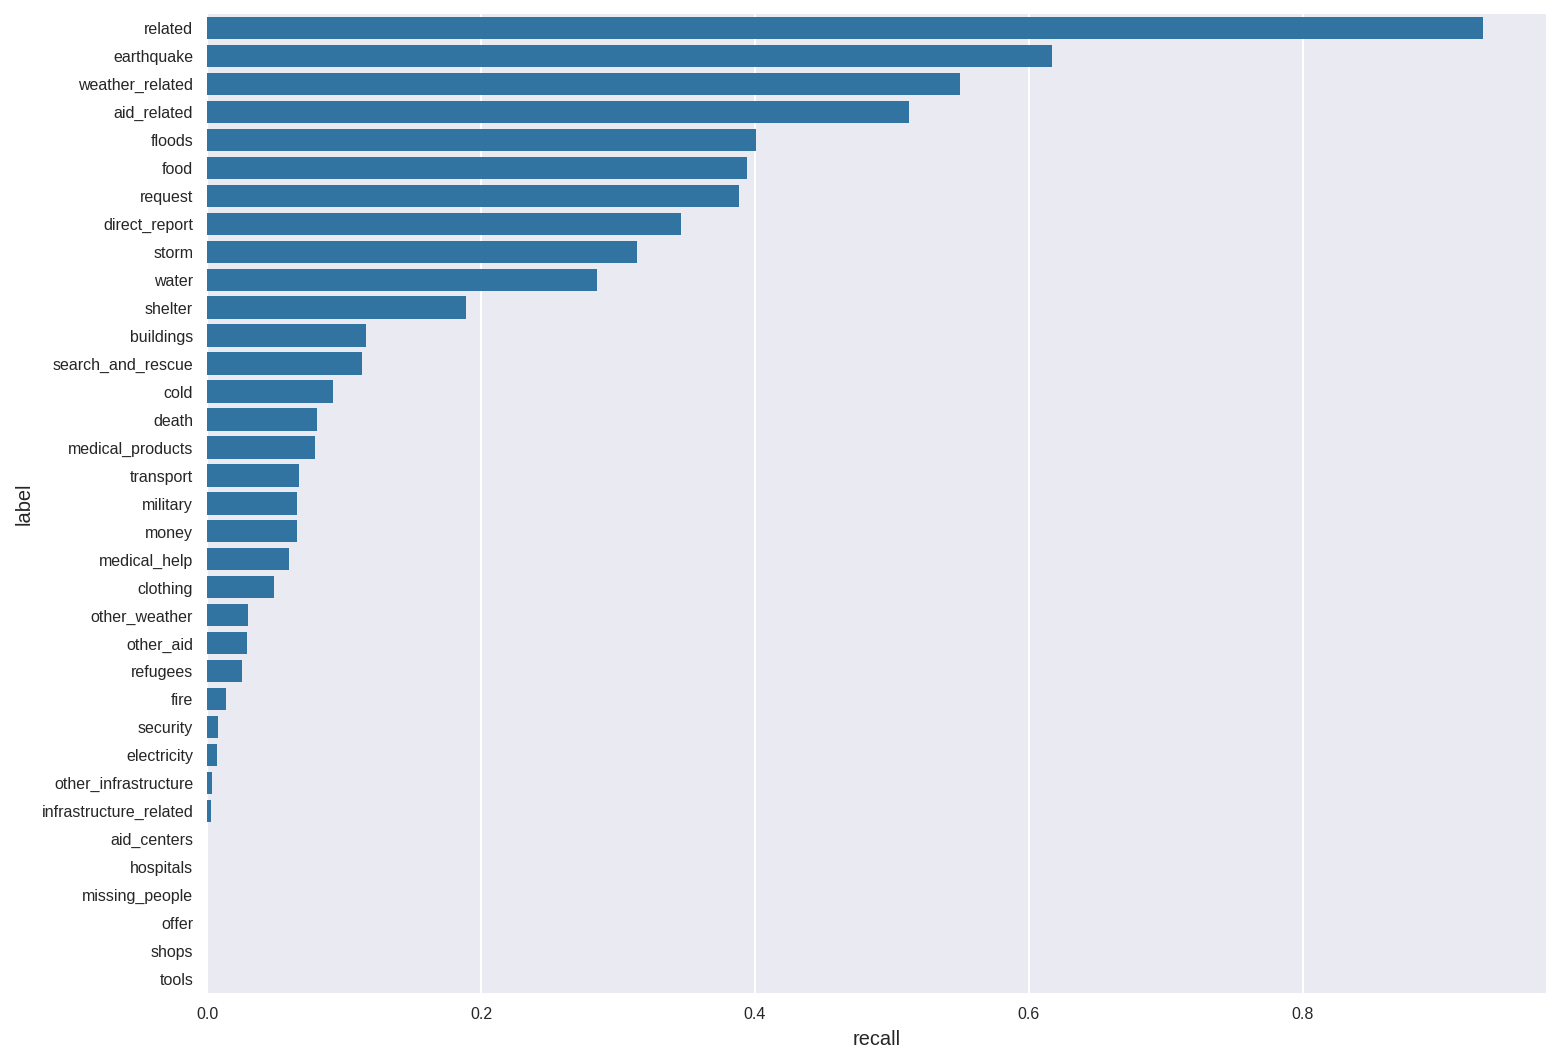

In [141]:

sns.barplot(data=metric_true, y='label', x='recall', color=blue)

### 6. Improve your model
Use grid search to find better parameters. 

In [163]:
#pipeline.get_params()

In [13]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier(
    criterion='entropy' )))
])

In [16]:
parameters = {
        'features__text_pipeline__vect__ngram_range': ((1, 1), (1, 2)),
        'features__text_pipeline__vect__max_df': (0.5, 0.75, 1.0),
        'features__text_pipeline__vect__max_features': (None, 5000, 10000),
        'features__text_pipeline__tfidf__use_idf': (True, False),
        'clf__n_estimators': [50, 100, 200],
        'clf__min_samples_split': [2, 3, 4],
        'features__transformer_weights': (
            {'text_pipeline': 1, 'starting_verb': 0.5},
            {'text_pipeline': 0.5, 'starting_verb': 1},
            {'text_pipeline': 0.8, 'starting_verb': 1},
        )
    }

parameters = {
        #'clf__estimator__criterion': ['gini', 'entropy'],
        #'clf__estimator__min_samples_split': [2,10,20],
        'clf__estimator__n_estimators': [10, 100, 1000],
        #'clf__estimator__verbose': [0,2,10],
        'clf__estimator__warm_start': [True, False],
    }

cv = GridSearchCV(pipeline, param_grid=parameters)



In [ ]:
%%time
cv.fit(X_train, y_train)

In [ ]:
cv.best_params_

In [156]:
y_pred = cv.predict(X_test)

In [157]:
y_pred = pd.DataFrame((y_pred), columns=y_test.columns)

In [158]:
metric_complete = pd.DataFrame(columns=['index', 'metric', 'metric_value', 'label'])

for label in labels:
    metric = precision_recall_fscore_support(y_test.loc[:,label], y_pred.loc[:,label])
    metric_df = pd.DataFrame({'precision': metric[0], 'recall': metric[1], 'fscore': metric[2]})
    metric_df = metric_df.reset_index().melt(id_vars='index', var_name='metric', value_name='metric_value')
    metric_df['label'] = label

    metric_complete = pd.concat([metric_complete, metric_df])
    

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [159]:


metric_true = metric_complete.query('index == 1').pivot(index='label', columns='metric', values='metric_value').sort_values(by=['recall', 'fscore'], ascending=False).reset_index()
metric_true.columns.name = None
metric_true.head(3)


,label,fscore,precision,recall
0,related,0.882459,0.837716,0.932251
1,earthquake,0.688391,0.911051,0.553191
2,aid_related,0.621610,0.740893,0.535410


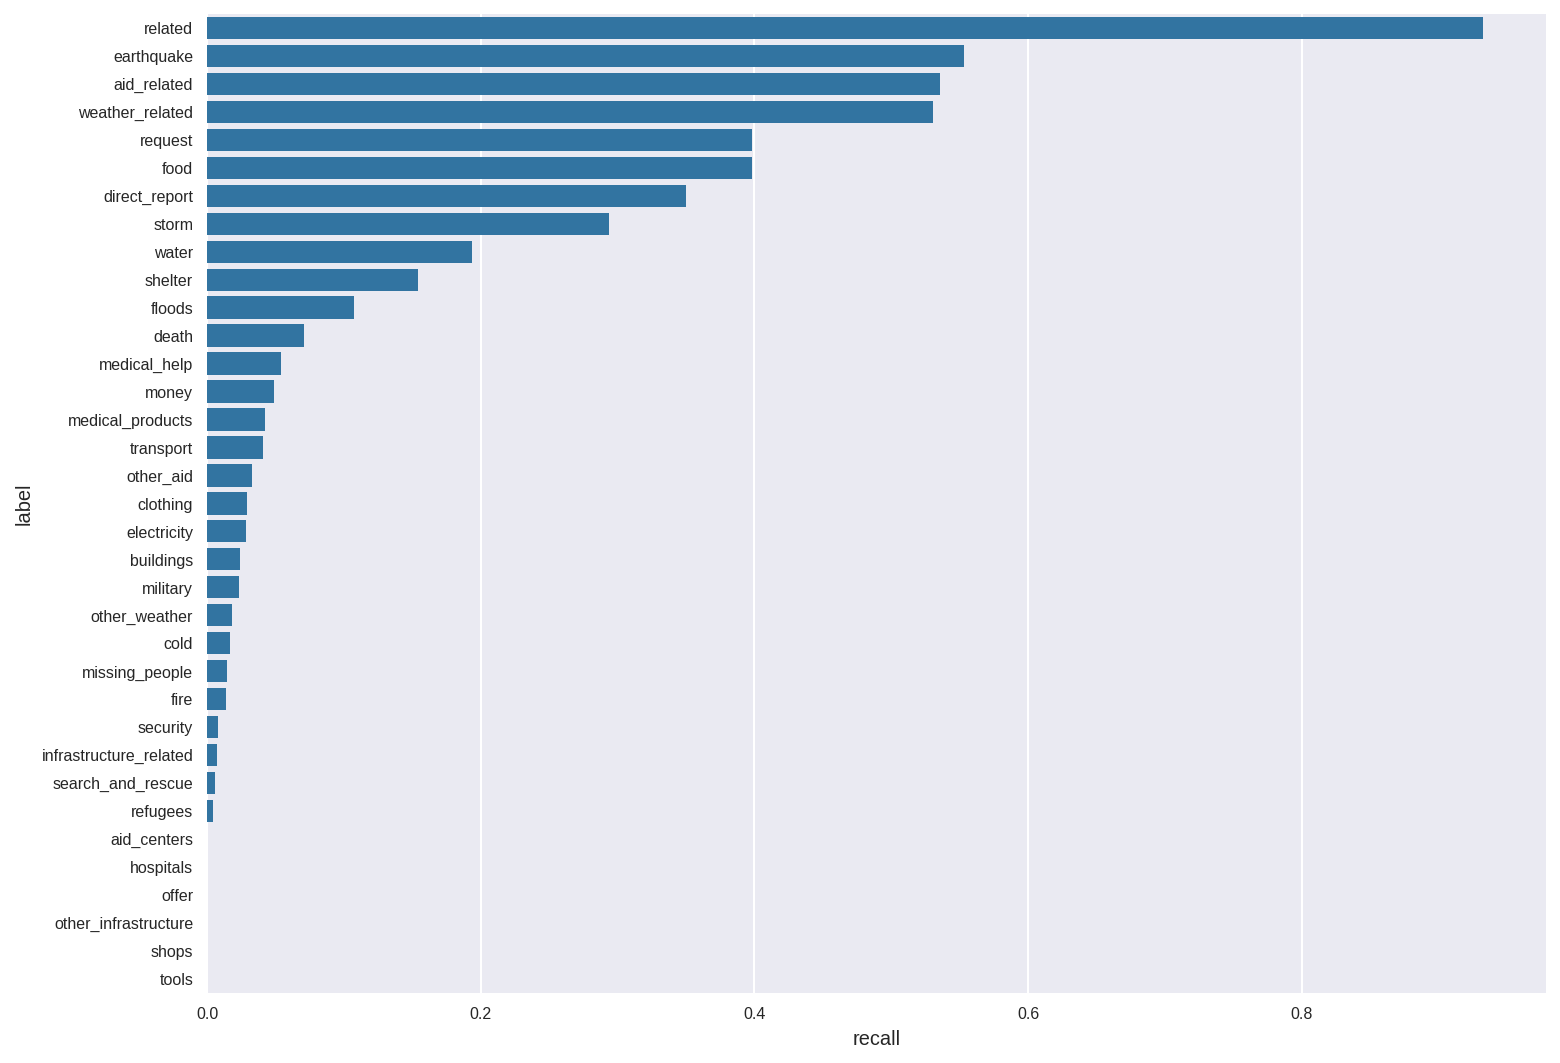

In [160]:

sns.barplot(data=metric_true, y='label', x='recall', color=blue)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.